In [1]:
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.5 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login

login()

Importing Dependencies

In [3]:
import numpy as np
import pandas as pd
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

Importing Models

In [4]:
model_name = "meta-llama/Llama-2-13b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model in 4-bit precision
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype="auto"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Add data

In [6]:
file_path = r"/content/all_data.csv"
data = pd.read_csv(file_path)

<ipython-input-6-08146613f25a>:2: DtypeWarning: Columns (8,9,31,32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [7]:
tasks = ['Free recall', 'Lexical decision', 'Cued recall', 'Single recognition', 'Associative recognition']

In [8]:
task_data = {task: data[data['condition'] == task] for task in tasks}

In [78]:
cleaned_tasks = {}

cleaned_tasks['Free recall'] = task_data['Free recall'][['subject', 'trial', 'resp.string','stim.string.left']].dropna()
cleaned_tasks['Lexical decision'] = task_data['Lexical decision'][['subject', 'stim.string.left', 'resp', 'rt']].dropna()
cleaned_tasks['Cued recall'] = task_data['Cued recall'][['subject', 'trial', 'stim.string.left', 'resp.string']].dropna()
cleaned_tasks['Single recognition'] = task_data['Single recognition'][['subject', 'stim.string.left', 'resp']].dropna()
cleaned_tasks['Associative recognition'] = task_data['Associative recognition'][['subject', 'stim.string.left', 'stim.string.right', 'resp']].dropna()

1. Free Recall

In [10]:
free_recall_data = cleaned_tasks['Free recall']

In [11]:
free_recall_data.shape

(59929, 3)

In [12]:
def generate_prompt_for_free_recall_V1(input_words: list):

  prompt = (
      "I want you to act as an expert in Retentive memory, you posess what they call having an 'eidetic' memory.\n"
      + "You are now provided with the following list of words to study, to remember.\n"
      + "List : "+ ", ".join(input_words)
      + "\n After studying them, recall as many words as you can from this given list"
  )

  return prompt


In [13]:
def generate_prompt_for_free_recall_V2(input_words: list):
    prompt = (
        "You are an expert with exceptional retentive and 'eidetic' memory skills. "
        "Your task is to carefully study and remember the following list of words:\n\n"
        + "Words: " + ", ".join(input_words) + "\n\n"
        + "After studying the list, recall as many words as you can from memory. "
        "Ensure your response includes only words from the provided list and avoid adding any extra words. "
        "Return your recalled words as a comma-separated list."
    )

    return prompt


In [25]:
def generate_prompt_for_free_recall_V3(input_words: list):
    prompt = (
        "Study the following list of words:\n"
        + ", ".join(input_words) +
        "\n\nRecall as many words as you can and provide them as a comma-separated list. Start your response with: 'Recalled words: '"
    )
    return prompt

In [28]:
def ask_llm(prompt, tokenizer, model):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=50, temperature=0.8, top_p=0.95 ) #
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

In [30]:
num_prompts = 5  # Number of prompts to test
sample_size = 10

for i in range(num_prompts):
  print(f"--------Example {i}-----------")
  sample_words = free_recall_data['resp.string'].dropna().sample(sample_size).tolist()
  prompt = generate_prompt_for_free_recall_V3(sample_words)
  print(f"Prompt - ")
  print(f"{prompt}")
  print("Response - ")
  response = ask_llm(prompt=prompt, tokenizer=tokenizer, model=model)
  print(f"{response}")

--------Example 0-----------
Prompt - 
Study the following list of words:
GRAND, lips, PERSONALITY, GUARD, REPORTS, STANDARDS, muscle, rubber, GRAIN, MINDS

Recall as many words as you can and provide them as a comma-separated list. Start your response with: 'Recalled words: '
Response - 
Study the following list of words:
GRAND, lips, PERSONALITY, GUARD, REPORTS, STANDARDS, muscle, rubber, GRAIN, MINDS

Recall as many words as you can and provide them as a comma-separated list. Start your response with: 'Recalled words: '

Recalled words: GRAND, lips, PERSONALITY, GUARD, REPORTS, STANDARDS, muscle, rubber, GRAIN, MINDS
--------Example 1-----------
Prompt - 
Study the following list of words:
PERFORMANCE, bank, flower, SEEK, METALS, INNER, MARRIAGE, YOUTH, CLAY, INVOLVE

Recall as many words as you can and provide them as a comma-separated list. Start your response with: 'Recalled words: '
Response - 
Study the following list of words:
PERFORMANCE, bank, flower, SEEK, METALS, INNER, MA

I tested 3 prompts, V1 and V2 was just echoing the prompt with some additional suggetions, but not outputting words. V3 was doing the same but at the end it is giving appropriate output

In [50]:
def generate_prompt_for_free_recall_V3_2(input_words: list):
    prompt = (
        "Study the following list of words:\n"
        + ", ".join(input_words) +
        "\n\nRecall as many words as you can and provide them as a comma-separated list and nothing else. Do not output anything other than the list. Start your response with: 'Recalled words: '"
    )
    return prompt

In [70]:
def generate_prompt_for_free_recall_V4(input_words: list):

    prompt = (
        "Study the following list of words:\n"
        + ", ".join(input_words) +
        "\n\nRecall as many words as you can and provide them as a comma-separated list. "
        "Do not output anything else. Your response should only be the list of words and nothing else. "
        "Start your response with: 'Recalled words: '."
    )
    return prompt



In [53]:
def ask_llm_v2(prompt, tokenizer, model):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.7,
        top_p=0.95,
        eos_token_id=tokenizer.eos_token_id  # Force model to stop at eos_token
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response


In [85]:
import re

def clean_response(response):
    """
    Extracts and cleans the recalled words from the LLM response.
    """
    marker = "Recalled words:"
    if marker in response:
        # Extract everything after 'Recalled words:'
        cleaned_response = response.split(marker, 1)[1].strip()

        # Remove any additional text after the first valid list of words
        word_match = re.search(r"^[A-Za-z, ]+", cleaned_response)
        if word_match:
            return word_match.group(0).strip()
    return "No recalled words found"



In [86]:
num_prompts = 5
sample_size = 10

for i in range(num_prompts):
  print(f"--------Example {i}-----------")
  sample_words = free_recall_data['resp.string'].dropna().sample(sample_size).tolist()
  prompt = generate_prompt_for_free_recall_V4(sample_words)
  print(f"Prompt - ")
  print("------")
  print(f"{prompt}")
  print("Response - ")
  print("------")
  response = ask_llm_v2(prompt=prompt, tokenizer=tokenizer, model=model)
  print(f"{response}")
  cleaned_response = clean_response(response)
  print(f"#### Cleaned:{cleaned_response}")

--------Example 0-----------
Prompt - 
------
Study the following list of words:
satisfaction, CARRIES, RECOGNIZE, AGREEMENT, JUSTICE, YARDS, FRIGHTENED, DISCOVERY, EXTREME, ADOPTED

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.
Response - 
------
Study the following list of words:
satisfaction, CARRIES, RECOGNIZE, AGREEMENT, JUSTICE, YARDS, FRIGHTENED, DISCOVERY, EXTREME, ADOPTED

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.

Example: Recalled words: satisfaction, CARRIES, RECOGNIZE, AGREEMENT, JUSTICE, YARDS, FRIGHTENED, DISCOVERY, EXTREME, ADOPTED

Please note that I will be grading your response based on the accuracy of the words you recall, so ma

In [79]:
def clean_response_debug(response):
    """
    Extracts the recalled words from the LLM response with debugging.
    """
    marker = "Recalled words:"
    if marker in response:
        # Debug: Print the text after 'Recalled words:'
        print(f"DEBUG: Found marker in response. Full response: {response}")

        # Extract everything after the marker
        cleaned_response = response.split(marker, 1)[1]
        print(f"DEBUG: Extracted after marker: {cleaned_response}")

        # Remove trailing newlines or additional text
        cleaned_response = cleaned_response.split("\n")[0].strip()
        print(f"DEBUG: After removing newlines: {cleaned_response}")

        return cleaned_response
    else:
        print(f"DEBUG: Marker '{marker}' not found in response.")
        return "No recalled words found"


In [80]:
num_prompts = 5
sample_size = 10

for i in range(num_prompts):
    print(f"-------- Example {i} -----------")
    sample_words = free_recall_data['resp.string'].dropna().sample(sample_size).tolist()
    prompt = generate_prompt_for_free_recall_V4(sample_words)
    print(f"Prompt - \n{prompt}")

    response = ask_llm_v2(prompt=prompt, tokenizer=tokenizer, model=model)
    print(f"Raw Response - \n{response}")

    cleaned_response = clean_response_debug(response)
    print(f"Cleaned Response: {cleaned_response}")


-------- Example 0 -----------
Prompt - 
Study the following list of words:
ENGINE, EXPLANATION, CUSTOMS, VOLUME, STUFF, ATTEMPTS, HEADED, ROPE, PLATE, INTERNATIONAL

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.
Raw Response - 
Study the following list of words:
ENGINE, EXPLANATION, CUSTOMS, VOLUME, STUFF, ATTEMPTS, HEADED, ROPE, PLATE, INTERNATIONAL

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.

Input:
Recall as many words as you can from the list above.

Expected Output:
Recalled words: ENGINE, EXPLANATION, CUSTOMS, VOLUME, STUFF, ATTEMPTS, HEADED, ROPE, PLATE, INTERNATIONAL
DEBUG: Found marker in response. Full response: Study the following list o

In [106]:
def clean_response_as_word_list(response):
    """
    Extracts recalled words by converting the response into a list of words, locating the marker,
    cleaning extraneous text, and removing recurring trailing text.
    """
    marker = "words:"
    marker2 = "Recall"
    trailing_text = "Recall as many words as you can and provide them as a comma-separated"

    response_words = response.split()  # Split response into individual words
    print(f"DEBUG: Response as word list:\n{response_words}\n")  # Debug: Show word list

    # Find the index of the marker in the list
    if marker in response_words:
        marker_index = response_words.index(marker)
        # Extract everything after the marker
        cleaned_words = response_words[marker_index + 1:]  # Skip the marker itself

        print(f"DEBUG: Extracted words after marker:\n{cleaned_words}\n")  # Debug: Show cleaned words

        # Join the words into a single string
        cleaned_response = " ".join(cleaned_words)

        return cleaned_response
    else:
        print(f"DEBUG: Marker '{marker}' not found in response.\n")
        return "No recalled words found"



In [107]:
num_prompts = 5
sample_size = 10

for i in range(num_prompts):
    print(f"-------- Example {i} -----------")
    sample_words = free_recall_data['resp.string'].dropna().sample(sample_size).tolist()
    prompt = generate_prompt_for_free_recall_V4(sample_words)
    print(f"Prompt - \n{prompt}")

    response = ask_llm_v2(prompt=prompt, tokenizer=tokenizer, model=model)
    print(f"Raw Response - \n{response}")

    cleaned_response = clean_response_as_word_list(response)
    print(f"Cleaned Response: {cleaned_response}")


-------- Example 0 -----------
Prompt - 
Study the following list of words:
BURIED, EAGER, ASSIGNED, VILLAGES, REPRESENTATIVES, COMBINE, MATCH, strike, survived, DIRECTED

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.
Raw Response - 
Study the following list of words:
BURIED, EAGER, ASSIGNED, VILLAGES, REPRESENTATIVES, COMBINE, MATCH, strike, survived, DIRECTED

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.

Example response:
Recalled words: BURIED, EAGER, ASSIGNED, VILLAGES, REPRESENTATIVES, COMBINE, MATCH, strike, survived

Note: The list of words is not in any particular order.
DEBUG: Response as word list:
['Study', 'the', 'following', 'list', 'of'

#### The automation for perfect formatting is taking too much time

In [108]:
def get_sample_words(data, sample_size=10):
    return data['resp.string'].dropna().sample(sample_size).tolist()

In [123]:
def get_human_response(data, sample_words):
    filtered_data = data[data['resp.string'].isin(sample_words)]

    human_response = filtered_data['resp.string'].dropna().unique()

    return ", ".join(human_response)


In [124]:
def get_model_response(prompt):
    print(f"Prompt: {prompt}")
    response = ask_llm_v2(prompt=prompt, tokenizer=tokenizer, model=model)
    print(response)
    model_response = input("Paste the model's output here: ")
    print(f"model response: {model_response}")
    return model_response

In [130]:
results = pd.DataFrame(columns=["input_words", "human_output", "model_output"])

# Workflow to generate prompts and collect responses
def generate_results(data, num_samples=5, sample_size=10):
    for _ in range(num_samples):

        input_words = get_sample_words(data, sample_size)
        print(f"Input words: {input_words}")
        prompt = generate_prompt_for_free_recall_V4(input_words)

        human_output = get_human_response(data, input_words)
        print(f"Human Oupt:\n {human_output}")

        model_output = get_model_response(prompt)

        #Append to results DataFrame
        #break
        results.loc[len(results)] = [", ".join(input_words), human_output, model_output]
    return results


In [131]:
results = generate_results(free_recall_data, num_samples=5, sample_size=10)

Input words: ['ACID', 'ASSUME', 'LOAD', 'CROP', 'SENATE', 'HABIT', 'FLOWS', 'OBVIOUS', 'PROMISE', 'WHEAT']
Human Oupt:
 WHEAT, ACID, PROMISE, FLOWS, LOAD, CROP, HABIT, ASSUME, SENATE, OBVIOUS
Prompt: Study the following list of words:
ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS, OBVIOUS, PROMISE, WHEAT

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.
Study the following list of words:
ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS, OBVIOUS, PROMISE, WHEAT

Recall as many words as you can and provide them as a comma-separated list. Do not output anything else. Your response should only be the list of words and nothing else. Start your response with: 'Recalled words: '.

Recalled words: ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS, OBVIOUS, PROMISE, WHEAT
Paste the model's output here: ACID, ASSUME, LOAD, CROP, SENATE

In [132]:
results

,input_words,human_output,model_output
0,"ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS...","WHEAT, ACID, PROMISE, FLOWS, LOAD, CROP, HABIT...","ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS..."
1,"KINGDOM, BANKS, FULLY, MOM, christian, dollar,...","christian, dollar, MOM, PRESS, FULLY, RAILROAD...","KINGDOM, BANKS, FULLY, MOM, christian, dollar,..."
2,"christian, ATTACHED, GENTLE, cloud, DEPENDENT,...","christian, cloud, BURIED, ATTACHED, GENTLE, IN...","GENTLE, COUNT, EFFECTIVELY, SONG"
3,"CROP, REMAINING, golden, COFFEE, WASTES, WEAPO...","golden, ANGER, temperatures, COFFEE, ROOF, WAS...","CROP, REMAINING, golden, COFFEE, WASTES, WEAPO..."
4,"PUSHING, CREATURE, mother, MERCHANTS, awful, P...","awful, CREATURE, mother, WORD, MERCHANTS, CAMP...","PUSHING, CREATURE, mother, MERCHANTS, awful, P..."


In [133]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(results):
    def tokenize(output):
        return set(output.replace(",", "").lower().split())

    results["human_tokens"] = results["human_output"].apply(tokenize)
    results["model_tokens"] = results["model_output"].apply(tokenize)

    precisions, recalls, f1s = [], [], []

    for _, row in results.iterrows():
        human_set = row["human_tokens"]
        model_set = row["model_tokens"]

        # True positives, false positives, and false negatives
        true_positives = len(human_set & model_set)
        false_positives = len(model_set - human_set)
        false_negatives = len(human_set - model_set)

        # Calculate precision, recall, and F1
        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    # Add metrics to results DataFrame
    results["precision"] = precisions
    results["recall"] = recalls
    results["f1_score"] = f1s

    # Return summary metrics
    return results, {
        "average_precision": sum(precisions) / len(precisions),
        "average_recall": sum(recalls) / len(recalls),
        "average_f1": sum(f1s) / len(f1s),
    }


In [136]:
results, summary_metrics = calculate_metrics(results)
print("Results with Metrics:\n")
results

Results with Metrics:



,input_words,human_output,model_output,human_tokens,model_tokens,precision,recall,f1_score
0,"ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS...","WHEAT, ACID, PROMISE, FLOWS, LOAD, CROP, HABIT...","ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS...","{promise, obvious, acid, flows, load, wheat, c...","{promise, obvious, acid, assume, load, flows, ...",1.0,1.0,1.000000
1,"KINGDOM, BANKS, FULLY, MOM, christian, dollar,...","christian, dollar, MOM, PRESS, FULLY, RAILROAD...","KINGDOM, BANKS, FULLY, MOM, christian, dollar,...","{railroad, card, press, winds, christian, full...","{railroad, card, press, mom, winds, christian,...",1.0,1.0,1.000000
2,"christian, ATTACHED, GENTLE, cloud, DEPENDENT,...","christian, cloud, BURIED, ATTACHED, GENTLE, IN...","GENTLE, COUNT, EFFECTIVELY, SONG","{cloud, gentle, buried, christian, insects, de...","{gentle, song, count, effectively}",1.0,0.4,0.571429
3,"CROP, REMAINING, golden, COFFEE, WASTES, WEAPO...","golden, ANGER, temperatures, COFFEE, ROOF, WAS...","CROP, REMAINING, golden, COFFEE, WASTES, WEAPO...","{temperatures, weapons, anger, remaining, wast...","{temperatures, weapons, anger, remaining, wast...",1.0,1.0,1.000000
4,"PUSHING, CREATURE, mother, MERCHANTS, awful, P...","awful, CREATURE, mother, WORD, MERCHANTS, CAMP...","PUSHING, CREATURE, mother, MERCHANTS, awful, P...","{merchants, creature, mother, perfectly, camp,...","{merchants, creature, mother, perfectly, camp,...",1.0,1.0,1.000000


In [135]:
print("\nSummary Metrics:\n", summary_metrics)


Summary Metrics:
 {'average_precision': 1.0, 'average_recall': 0.8800000000000001, 'average_f1': 0.9142857142857143}


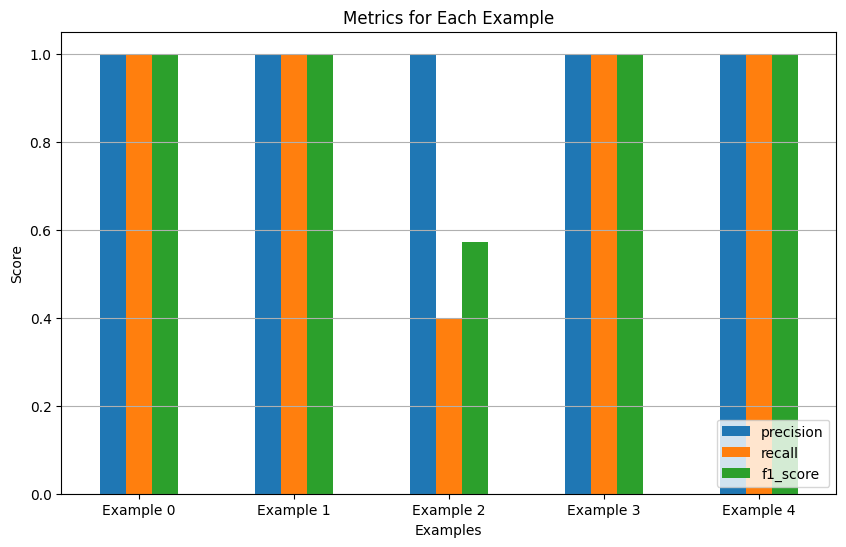

In [137]:
import matplotlib.pyplot as plt

# Plot metrics for each example
results[["precision", "recall", "f1_score"]].plot(kind="bar", figsize=(10, 6))
plt.title("Metrics for Each Example")
plt.xlabel("Examples")
plt.ylabel("Score")
plt.xticks(range(len(results)), labels=[f"Example {i}" for i in range(len(results))], rotation=0)
plt.legend(loc="lower right")
plt.grid(axis="y")
plt.show()

In [138]:
for idx, row in results.iterrows():
    print(f"Example {idx} Comparison")
    print(f"Input Words: {row['input_words']}")
    print(f"Human Output: {row['human_output']}")
    print(f"Model Output: {row['model_output']}")
    print(f"Precision: {row['precision']:.2f}, Recall: {row['recall']:.2f}, F1 Score: {row['f1_score']:.2f}")
    print("-" * 80)

Example 0 Comparison
Input Words: ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS, OBVIOUS, PROMISE, WHEAT
Human Output: WHEAT, ACID, PROMISE, FLOWS, LOAD, CROP, HABIT, ASSUME, SENATE, OBVIOUS
Model Output: ACID, ASSUME, LOAD, CROP, SENATE, HABIT, FLOWS, OBVIOUS, PROMISE, WHEAT
Precision: 1.00, Recall: 1.00, F1 Score: 1.00
--------------------------------------------------------------------------------
Example 1 Comparison
Input Words: KINGDOM, BANKS, FULLY, MOM, christian, dollar, WINDS, RAILROAD, CARD, PRESS
Human Output: christian, dollar, MOM, PRESS, FULLY, RAILROAD, CARD, BANKS, KINGDOM, WINDS
Model Output: KINGDOM, BANKS, FULLY, MOM, christian, dollar, WINDS, RAILROAD, CARD, PRESS
Precision: 1.00, Recall: 1.00, F1 Score: 1.00
--------------------------------------------------------------------------------
Example 2 Comparison
Input Words: christian, ATTACHED, GENTLE, cloud, DEPENDENT, BURIED, INSECTS, COUNT, EFFECTIVELY, SONG
Human Output: christian, cloud, BURIED, ATTACHED, GENTL

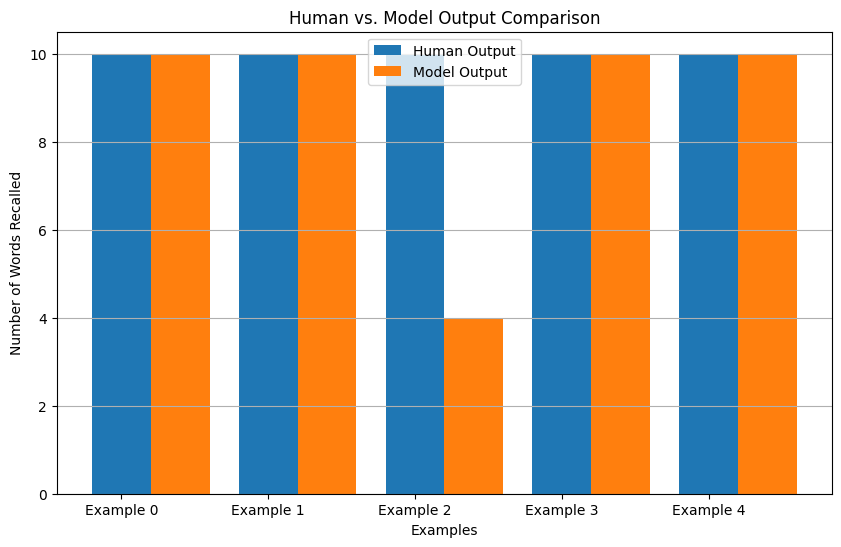

In [141]:
import matplotlib.pyplot as plt
import pandas as pd



# Prepare data for visualization
x = range(len(results))
human_lengths = results["human_output"].apply(lambda x: len(x.split(",")))
model_lengths = results["model_output"].apply(lambda x: len(x.split(",")))

# Plot human vs. model response lengths
plt.figure(figsize=(10, 6))
plt.bar(x, human_lengths, width=0.4, label="Human Output", align='center')
plt.bar([i + 0.4 for i in x], model_lengths, width=0.4, label="Model Output", align='center')

plt.title("Human vs. Model Output Comparison")
plt.xlabel("Examples")
plt.ylabel("Number of Words Recalled")
plt.xticks(x, [f"Example {i}" for i in x])
plt.legend()
plt.grid(axis="y")
plt.show()
